# **Introduction**

The following notebook focuses on imbalanced binary classification problems. Some real world scenarios that utilise machine learning solutions where such problems can be encountered are that of loan approval systems, credit risk analysis, etc where one label class dominates the other with regards to the number of observations. If not not handled carefully, data models won't perform as per the expectations. The project discusses some of the common errors and  how to avoid them.

Note: This notebook concentrates only on data modeling and does not contain any EDA.

**The goal:** The problem that is going to be used to demonstrate the above concept is that of predicting customers of an Insurance company who have health insurances set up with that firm and would be interested in taking up automobile insurance as well. The company has recently expanded their services to include automobile insurance and would like to focus their resources and efforts on customers who are more likely to subscribe.

**Dataset used:** The dataset that is is being used is from Kaggle. It can be found [here.](https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice) Credits to the person who compiled the dataset.


Let's get started!

.

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# **Data preprocessing**

In this section, we are going to import the dataset and visualise it to understand the flavour of the data and the steps to process it for our final task, i.e. predicting if a customer will go for the automobile insurance or not. Most of the code in this section is self explanatory and easy to follow along.

.

In [14]:
# read data files (Enter your own respective file locations)

df1 = pd.read_csv('/content/drive/MyDrive/insurance_prediction/aug_train.csv')
df2 = pd.read_csv('/content/drive/MyDrive/insurance_prediction/aug_test.csv')
ans = np.load('/content/drive/MyDrive/insurance_prediction/answer.npy')

In [15]:
# I am going to combine both train and test sets with random shuffling to create a master dataset

df2['Response'] = ans
df = pd.concat([df1, df2]).sample(frac=1, random_state=0).reset_index(drop=True)

In [16]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,250452,Male,35,1,28.0,0,1-2 Year,Yes,39183.0,26.0,142,0
1,366939,Female,49,1,37.0,0,1-2 Year,Yes,35649.0,26.0,178,0
2,185895,Male,36,1,28.0,0,1-2 Year,Yes,22364.0,26.0,145,1
3,454455,Male,38,1,41.0,0,< 1 Year,Yes,2630.0,157.0,145,1
4,387968,Female,66,1,3.0,1,1-2 Year,No,15088.0,26.0,232,0


In [ ]:
df.shape    # shape of the complete dataset

(460427, 12)

In [ ]:
df.isna().sum()     # checking for null values

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [ ]:
df.nunique()      # checking number of unique values in each feature

id                      460427
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           51002
Policy_Sales_Channel       156
Vintage                    290
Response                     2
dtype: int64

.

There are 460427 unique rows in the dataset. I have reduced the number of rows by random sampling to speed up the training process as this task is only for demonstration. But the proportion of the number of positive labels to number of negative labels from the original dataset has been maintained. There are more elegant ways to do this but I have used a pretty straightforward method.

.

In [ ]:
print('Size of dataframe', len(df))
print('Fraction not opting for vehicle insurance:', round((Counter(df['Response'])[0]/len(df))*100), '%')
print('Fraction opting for vehicle insurance:', round((Counter(df['Response'])[1]/len(df))*100), '%')

Size of dataframe 460427
Fraction not opting for vehicle insurance: 84 %
Fraction opting for vehicle insurance: 16 %


In [17]:
mdf1 = df[df['Response']==0].sample(n=8400, random_state=9)
mdf2 = df[df['Response']==1].sample(n=1600, random_state=9)
mdf = pd.concat([mdf1, mdf2]).sample(frac=1, random_state=0).reset_index(drop=True)

print('Size of reduced dataframe', len(mdf))
print('Fraction not opting for vehicle insurance:', round((Counter(mdf['Response'])[0]/len(mdf))*100), '%')
print('Fraction opting for vehicle insurance:', round((Counter(mdf['Response'])[1]/len(mdf))*100), '%')

Size of reduced dataframe 10000
Fraction not opting for vehicle insurance: 84 %
Fraction opting for vehicle insurance: 16 %


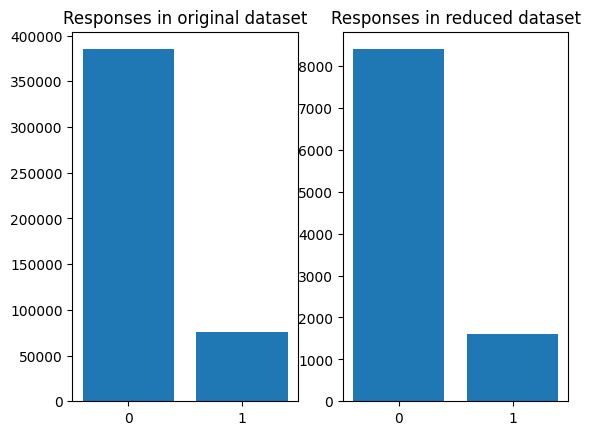

In [6]:
plt.subplot(1,2,1)
plt.bar(Counter(df['Response']).keys(),Counter(df['Response']).values())
plt.xticks([0,1])
plt.title('Responses in original dataset')
plt.subplot(1,2,2)
plt.bar(Counter(mdf['Response']).keys(),Counter(mdf['Response']).values())
plt.xticks([0,1])
plt.title('Responses in reduced dataset')
plt.show()

In [18]:
df = mdf.copy()

.

We can clearly visualise the imbalance of the number of observations. 0 denotes the people who have not opted for automobile insurance from the insurance firm and 1 denotes those who have. It agrees with our intuition that only a small fraction of the original number of clients will agree to enroll themselves into a new scheme.

Although I had said before that there will not be any EDA in this project, it can be mentioned that certain features such as region code, vehicle age and policy sales channel can be important features to analyse for targeted advertisement and marketing to draw more customers. With that out of the way, let's carry on.

.

In [ ]:
df.shape

(10000, 12)

In [19]:
df.drop(columns=['id'], inplace=True)
categorical_features = [x for x in df.columns.values if x not in ['Age', 'Annual_Premium', 'Response']]       # defining categorcal features
df = pd.get_dummies(df, columns = categorical_features)               # a quicker way to encode categorical features than one-hot encoding
df.head()

,Age,Annual_Premium,Response,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Region_Code_0.0,Region_Code_1.0,Region_Code_2.0,...,Vintage_290,Vintage_291,Vintage_292,Vintage_293,Vintage_294,Vintage_295,Vintage_296,Vintage_297,Vintage_298,Vintage_299
0,31,31737.0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,67,43707.0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,77,2630.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24,28204.0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,49,47437.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# define features and labels

features = list(df.columns.values)
features.remove('Response')

labels = ['Response']

In [21]:
X = df[features]
y = df[labels]

.

**Scaling the features:** I have used min max scaler in this case to preserve the binary form of the data in the categorical features. Normally standard scaler should be used as the only 2 continuous distribution features (age and annual premium) do not have a defined minimum and maximum but it should be fine as it is being applied on the whole dataset. Problems may arise if first min-max scaler is used to 'fit-transform' training dataset and then 'transform' is applied on test. In that case, standard scaler can be applied to individual features such as df[feature] = scaler.fit_transform(df[feature])

.

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))

scaled_X = scaler.fit_transform(X)
pd.DataFrame(scaled_X, columns=X.columns.values).head()

,Age,Annual_Premium,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Region_Code_0.0,Region_Code_1.0,Region_Code_2.0,Region_Code_3.0,...,Vintage_290,Vintage_291,Vintage_292,Vintage_293,Vintage_294,Vintage_295,Vintage_296,Vintage_297,Vintage_298,Vintage_299
0,0.171875,0.124894,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.734375,0.176256,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.890625,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.062500,0.109735,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.453125,0.192261,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Data Modelling**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=9)

Finally we have arrived at the data modelling part. The features and labels have been split into train and test. In the bar plot below, we can see that the proportion of imbalance between the label classes has been maintained after the split.

.

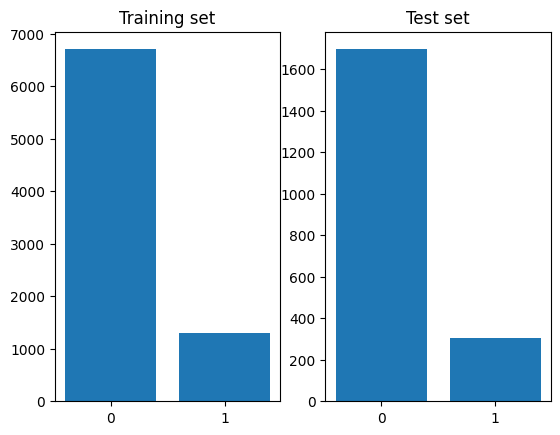

In [13]:
plt.subplot(1,2,1)
plt.bar(Counter(y_train['Response']).keys(),Counter(y_train['Response']).values())
plt.xticks([0,1])
plt.title('Training set')
plt.subplot(1,2,2)
plt.bar(Counter(y_test['Response']).keys(),Counter(y_test['Response']).values())
plt.xticks([0,1])
plt.title('Test set')
plt.show()

## Base classifier

Random Forest classifier has been used for this problem as decisions such as this do not follow a strict sequence. For example, a person may have an old vehicle that has suffered damage in the past so they might want the car insurance but they are already paying a high premium for health insurance and therefore cannot afford the former. Or a certain policy sales channel might be very efficient at selling policies but it wouldn't matter if the customer doesn't have a valid driving license (or doesn't have an automobile).


In the first instance, we will test the performance of the base classifier (with default parameters) on the imbalanced dataset and discuss the results.

.

In [ ]:
# checking performance of base classifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1696
           1       0.49      0.29      0.37       304

    accuracy                           0.85      2000
   macro avg       0.69      0.62      0.64      2000
weighted avg       0.82      0.85      0.83      2000



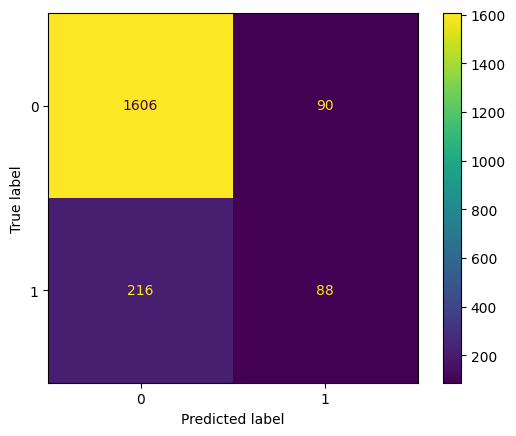

In [ ]:
metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_test, y_pred)).plot()
plt.show()

.

We see in the classification report that the values of precision, recall and f-score is close to 1 (which is good) for label 0 but very low for label 1 (label 1 = those who bought auto insurance policies). It is more clear in the confusion matrix. Our model was able to predict those who won't buy policies quite well but due to the imbalance, it was not able to predict the ones who bought auto insurance policies. It was more biased towards 0 labels as they were much higher in number in the training set.

This is where we see that the model is not performing as expected. In a business, there will be a certain tolerance towards misclassification of the negative labels (in this case 0) as positive (1). But misclassification of a 1 as 0 means rejecting a potential customer which is bad for the business. Often, the actual challenge in these problems is to predict the minority classes well. For example, in student admissions, out of thousands of applications, only a few will be selected. In this case, the selected students are the minority class.

A natural instinct to solve such problems would be to try and increase the accuracy of the model by tuning the hyperparameters. We will try it in the next section.

.

## Hyperparameter tuning with different scoring metrics

In [ ]:
# defining the list of parameters and then using grid search cv
# to determine the best combination against a chosen scoring metric

n_estimators = [10, 50, 100, 200, 500]
max_features = [None, 'sqrt', 'log2']
class_weight = [None, 'balanced']
n_jobs = [-1]

grid_rf = {'n_estimators': n_estimators,
           'max_features': max_features,
           'class_weight': class_weight,
           'n_jobs': n_jobs}

### Scoring metric: Accuracy

In [ ]:
randomforest_gridsearch_acc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=5, scoring='accuracy', verbose=4)
randomforest_gridsearch_acc.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1696
           1       0.51      0.28      0.36       304

    accuracy                           0.85      2000
   macro avg       0.69      0.61      0.64      2000
weighted avg       0.82      0.85      0.83      2000



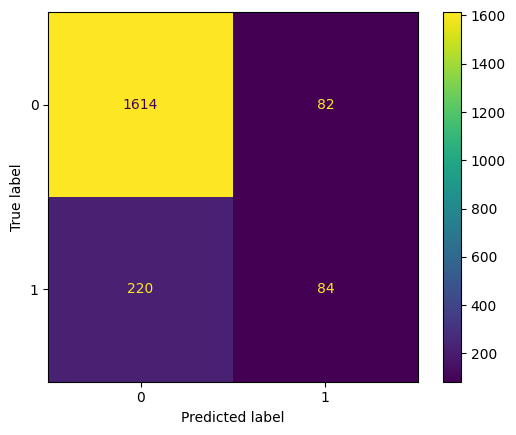

In [ ]:
model = randomforest_gridsearch_acc.best_estimator_
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_test, y_pred)).plot()
plt.show()

.

We find almost no difference in the results between the base classifier and classifier tuned for accuracy although the value of which is quite high; 85%, which should be considered quite good. But no, the reason for the high accuracy value is the higher number of 0 labels that were correctly predicted.

This revelation changes our goal. Now we are not looking to increase the overall accuracy of the model but trying to reduce the misclassification of the minority class (number of 1s predicted as 0). To do this, we have to change our scoring metric for hyperparameter tuning. We can use precision or f-score (combination of precision and recall) to do so. There is another scoring parameter called ROC AUC which gives the area under the ROC curve which is a plot of true positives vs false positives. For more on scoring parameters, refer to the scikit learn page [here.](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)


We will try a couple of these scoring parameters in the next sections. The method will remain the same, only the results need to be checked for each scoring metric.

.

### Scoring metric: F-score

In [ ]:
randomforest_gridsearch_f1 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=5, scoring='f1_weighted', verbose=4)
randomforest_gridsearch_f1.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1696
           1       0.48      0.47      0.48       304

    accuracy                           0.84      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.84      0.84      0.84      2000



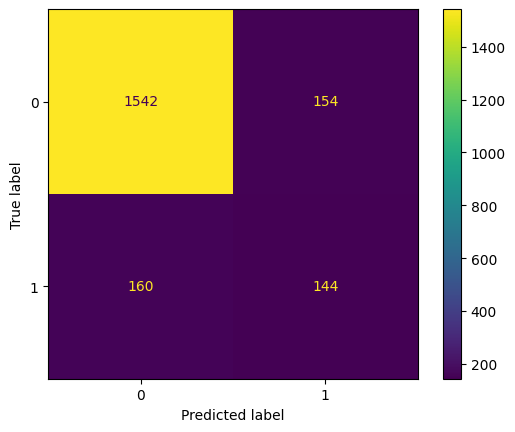

In [ ]:
model = randomforest_gridsearch_f1.best_estimator_
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_test, y_pred)).plot()
plt.show()

### Scoring metric: ROC AUC

In [ ]:
randomforest_gridsearch_roc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=5, scoring='roc_auc_ovo_weighted', verbose=4)
randomforest_gridsearch_roc.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1696
           1       0.50      0.52      0.51       304

    accuracy                           0.85      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.85      0.85      0.85      2000



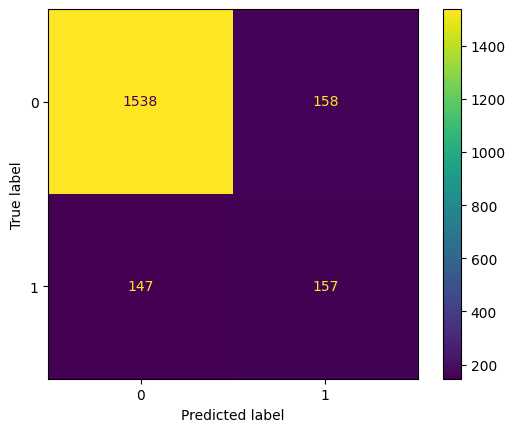

In [ ]:
model = randomforest_gridsearch_roc.best_estimator_
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_test, y_pred)).plot()
plt.show()

.

In the above 2 scenarios, we find our model performance improved quite a bit with regards to the minority class (label 1) although it might lead to a drop in accuracy due to some more 0 labels being misclassified. But as stated before, in such problems there will a certain tolerance towards that. Associating example, rejecting a loan for someone who can repay it (majority class) is less risky for a bank than approving it for someone who cannot pay it back (minority class).

.

# **Synthetic Minority oversampling technique (SMOTE)**

When it comes to tackling imbalance in label classes, a very common technique is random over sampling. In this, random entries with the minority class label are duplicated in the training set so that its number can match up to that of the majority class. While this method may be useful in image classifications along with some rotation and skew, it definitely does not add any new information in our current problem to help us predict the minority class better. Therefore we choose SMOTE to create synthetic samples of the minority class.

SMOTE uses k-nearest neighbors to determine the samples closest to randomly chosen samples and creates new synthetic samples on the line joining the closest samples in the feature space. There is a great documentation on SMOTE along with visualisations of how it works which can be found [here.](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) Alternatively, you can just type SMOTE on google and this will be one of the first results.

.

## Oversampling minority class

In [ ]:
# Oversampling minority class to match with the number of samples of majority class

oversampler = SMOTE(sampling_strategy='auto', k_neighbors=3)

print('Before oversampling: ', Counter(y_train['Response']))

X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

print('After oversampling: ', Counter(y_train_os['Response']))


Before oversampling:  Counter({0: 6704, 1: 1296})
After oversampling:  Counter({0: 6704, 1: 6704})


              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1696
           1       0.47      0.62      0.54       304

    accuracy                           0.84      2000
   macro avg       0.70      0.75      0.72      2000
weighted avg       0.86      0.84      0.85      2000



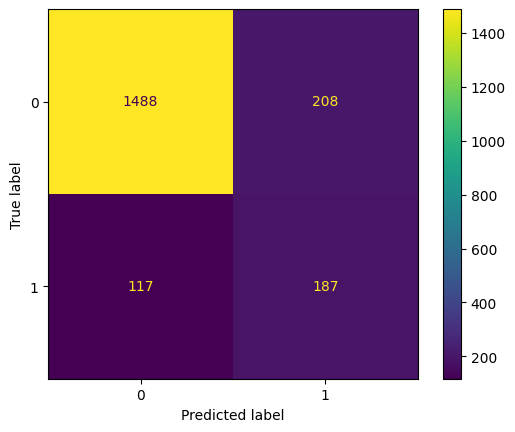

In [ ]:
# trying base classifier on oversampled training set

model = RandomForestClassifier()
model.fit(X_train_os, y_train_os)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_test, y_pred)).plot()
plt.show()

.

It is already better than our last base classifier performance and all previous tuned classifiers. Until now we have only oversampled the minority class. But the research paper on SMOTE recommends not to oversample to completely match the number of samples but only till a fraction of the majority class to avoid making too many synthetic samples that never occur in real life. Follwed by undersampling of the majority class. It might seem a bit confusing in words and perhaps easier to follow in the code below.

.

## Oversampling minority class and undersampling majority class

In [ ]:
# Oversampling minority class to have 30% of the total samples in majority class
# undersampling the majority class to have 60% more samples than the majority class
# the above percentages have been chosen by me to have close but not equal number of samples in both classes.

oversampler = SMOTE(sampling_strategy=0.3, k_neighbors=3)
undersampler = RandomUnderSampler(sampling_strategy=0.6)

print('Before synthetic oversampling: ', Counter(y_train['Response']))

X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

print('After oversampling minority class: ', Counter(y_train_os['Response']))

X_train_os_us, y_train_os_us = undersampler.fit_resample(X_train_os, y_train_os)

print('After undersampling majority class: ', Counter(y_train_os_us['Response']))

Before synthetic oversampling:  Counter({0: 6704, 1: 1296})
After oversampling minority class:  Counter({0: 6704, 1: 2011})
After undersampling majority class:  Counter({0: 3351, 1: 2011})


              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1696
           1       0.46      0.77      0.57       304

    accuracy                           0.82      2000
   macro avg       0.70      0.80      0.73      2000
weighted avg       0.88      0.82      0.84      2000



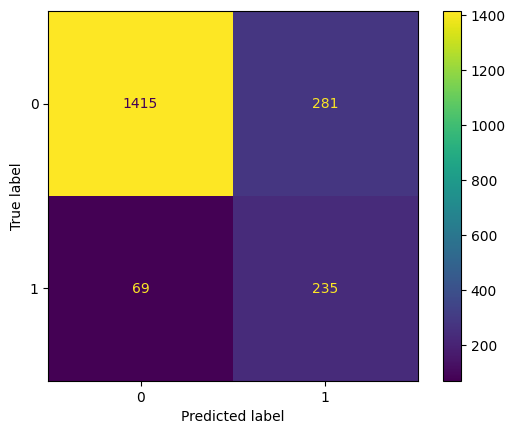

In [ ]:
# trying base model

model = RandomForestClassifier()
model.fit(X_train_os_us, y_train_os_us)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_test, y_pred)).plot()
plt.show()

.

And you can see the difference for yourself. Although the accuracy decreased a little bit, the model performance on the minority class improved a lot. Another vital thing to note is that synthetic oversampling should be performed only on training set and never on the test set.


Having said that, let's try tuning the model parameters with different scoring parameters as we did before.

.

### Scoring metric: F-score

In [ ]:
randomforest_gridsearch_f1_os_us = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=5, scoring='f1_weighted', verbose=4)
randomforest_gridsearch_f1_os_us.fit(X_train_os_us, y_train_os_us)

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1696
           1       0.45      0.79      0.58       304

    accuracy                           0.82      2000
   macro avg       0.71      0.81      0.73      2000
weighted avg       0.88      0.82      0.84      2000



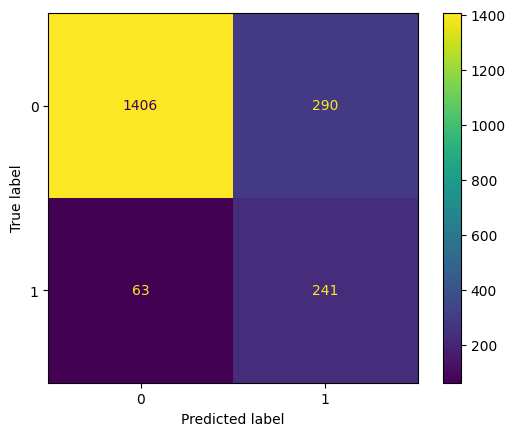

In [ ]:
model = randomforest_gridsearch_f1_os_us.best_estimator_
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_test, y_pred)).plot()
plt.show()

### Scoring metric: Precision

In [ ]:
randomforest_gridsearch_pres_os_us = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=5, scoring='precision_weighted', verbose=4)
randomforest_gridsearch_pres_os_us.fit(X_train_os_us, y_train_os_us)

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1696
           1       0.45      0.78      0.57       304

    accuracy                           0.82      2000
   macro avg       0.70      0.81      0.73      2000
weighted avg       0.88      0.82      0.84      2000



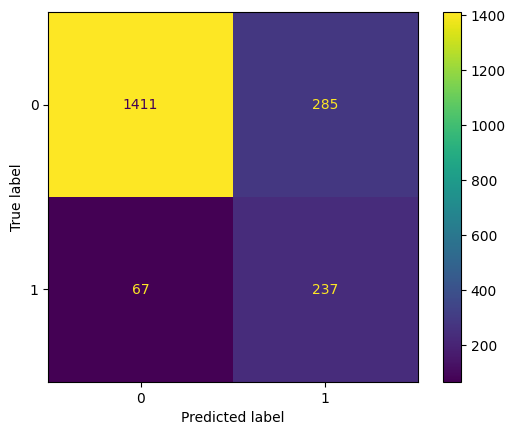

In [ ]:
model = randomforest_gridsearch_pres_os_us.best_estimator_
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(y_test, y_pred)).plot()
plt.show()

.

It appears that the model scored on f-score performs the best for this set of data and hyperparameters. Additional changes can probably be made to improve the model performance even more. Different scoring parameters can be used in the grid search CV as per the problem requirement but we were definitely able to mitigate some of the bias from the imbalanced dataset and train our model to predict minority classes better.